**Лабораторная работа №3: KNN**

**Выполнила: Мишагина Валерия 6133**



Датасет -  [2024 TMDB Latest Movie Data  ](https://www.kaggle.com/datasets/hafiznouman786/2024-tmdb-latest-movie-data?resource=download)

**№1.** Считать в `pandas.DataFrame` любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.

In [179]:
import pandas as pd
import random
import numpy as np
from matplotlib import pyplot as plt
data = pd.read_csv('movies2.csv')

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

**№2.** Привести описание датасета.

Описание столбцов датасета [2024 TMDB Latest Movie Data  ](https://www.kaggle.com/datasets/hafiznouman786/2024-tmdb-latest-movie-data?resource=download)

* movie_id: Unique identifier for each movie.
* title: Title of the movie.
* release_date: Release date of the movie.
* genre: Genre(s) of the movie.
* overview: Brief summary or synopsis of the movie.
* popularity: Popularity score of the movie.
* vote_average: Average rating of the movie.
* vote_count: Number of votes the movie has received.



In [180]:
# информация о данных в DataFrame, тип данных признаков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9400 non-null   int64  
 1   original_title  9400 non-null   object 
 2   overview        9399 non-null   object 
 3   release_date    9400 non-null   object 
 4   popularity      9400 non-null   float64
 5   vote_average    9400 non-null   float64
 6   vote_count      9400 non-null   int64  
 7   genre_names     9400 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 587.6+ KB


In [181]:
# размерность датасета
data.shape

(9400, 8)

# Бинарная классификация

**Осуществить предобработку данных (избавиться от null, убрать некоторые признаки и т.п.) - "подчистить данные"**




In [182]:
# загрубим значение даты выхода для группировке по годам
data['release_year'] = data["release_date"].apply(lambda e:  str(round(int(e[0:4]), -1)) + '-e')

In [183]:
#загрубим значения датасета. Выделим среди жанров фильма "главный"
data = data[data['genre_names'] != '[]']
data['main_genre'] = data["genre_names"].apply(lambda e: e.split('\'')[1])

<ipython-input-183-76eda0bdf38b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['main_genre'] = data["genre_names"].apply(lambda e: e.split('\'')[1])


In [184]:
# округление 'popularity' до десятков
data['popularity'] = data["popularity"].apply(lambda e:  round(int(e), -1))

In [185]:
data.isna().sum()

id                0
original_title    0
overview          1
release_date      0
popularity        0
vote_average      0
vote_count        0
genre_names       0
release_year      0
main_genre        0
dtype: int64

In [186]:
# избавляемся от пропусков
data = data.dropna(subset=["overview"])

In [187]:
data['is_high_rating'] = data["vote_average"].apply(lambda e:   e > 6)

In [188]:
data.drop('overview', axis=1, inplace=True)
data.drop('original_title', axis=1, inplace=True)
data.drop('release_date', axis=1, inplace=True)
data.drop('genre_names', axis=1, inplace=True)
data.drop('id', axis=1, inplace=True)

In [189]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9396 entries, 0 to 9399
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   popularity      9396 non-null   int64  
 1   vote_average    9396 non-null   float64
 2   vote_count      9396 non-null   int64  
 3   release_year    9396 non-null   object 
 4   main_genre      9396 non-null   object 
 5   is_high_rating  9396 non-null   bool   
dtypes: bool(1), float64(1), int64(2), object(2)
memory usage: 449.6+ KB


Будем определять is_high_rating по оставльным признакам

**Закодировать категориальные признаки при необходимости**

Закодируем категориальные признаки Label Encoder'ом (уникальных значений больше 10)

In [190]:
category_cols = ['release_year', 'main_genre']
dicts = []
for col in category_cols:
  print (col)
  print(len(data[col].unique()))
  keys, values = pd.factorize(data[col].unique())
  d = dict(zip(values, keys))
  data[col] = data[col].replace(d)
  dicts.append(d)

release_year
12
main_genre
18


In [191]:
data

,popularity,vote_average,vote_count,release_year,main_genre,is_high_rating
0,120,8.705,26221,0,0,True
1,170,8.695,19877,1,0,True
2,160,8.576,12001,1,0,True
3,80,8.567,15409,0,0,True
4,80,8.541,8276,2,0,True
...,...,...,...,...,...,...
9395,10,3.724,346,3,10,False
9396,10,3.701,1317,5,10,False
9397,20,3.681,329,3,1,False
9398,10,3.300,441,7,3,False


**Выбрать какое-нибудь значение гиперпараметра `k`**


In [192]:
k = 3

**Разбить выборку на обучающую и тестовую**

In [193]:
x = data.drop('is_high_rating', axis=1)
y = data['is_high_rating']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75)

In [194]:
# размерности выборок
print(f"X_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (7047, 5)
y_train shape: (7047,)
X_test shape: (2349, 5)
y_test shape: (2349,)


In [195]:
cols = list(x_train.columns)

**Осуществить бинарную классификацию**



In [196]:
model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
# обучение
model.fit(x_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

**Посчитать метрики:** *accuracy, precision, recall, f-measure*, а также составить` classification_report`

In [197]:
preds = model.predict(x_test)

In [198]:
print(f'Accuracy: {accuracy_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1-measure: {f1_score(y_test, preds)}')
print(classification_report(y_test, preds))

Accuracy: 0.7586206896551724
Precision: 0.8186758893280632
Recall: 0.8922994076467421
F1-measure: 0.8539036330842567
              precision    recall  f1-score   support

       False       0.38      0.25      0.31       492
        True       0.82      0.89      0.85      1857

    accuracy                           0.76      2349
   macro avg       0.60      0.57      0.58      2349
weighted avg       0.73      0.76      0.74      2349



**Нормализовать данные** (`StandardScaler` или `MinMaxScaler`)



In [199]:
scaler = StandardScaler()
scaler.fit(x[cols])
scaled = scaler.transform(x_train[cols])
x_train_scaled = pd.DataFrame(scaled, columns=cols)

In [200]:
x_train_scaled

,popularity,vote_average,vote_count,release_year,main_genre
0,-0.248246,-0.222082,-0.490133,-0.525426,0.506053
1,-0.248246,0.794444,-0.464588,0.057237,-1.008237
2,0.083628,-0.103168,-0.014808,1.805225,1.155034
3,-0.248246,0.080958,-0.345595,-2.273414,-0.142929
4,-0.248246,-1.325557,-0.387308,-2.273414,0.506053
...,...,...,...,...,...
7042,0.083628,0.592418,0.364482,-0.525426,-1.008237
7043,-0.358871,-1.581287,-0.475906,0.639900,-1.008237
7044,-0.248246,-0.046907,0.184376,-0.525426,-0.791910
7045,0.415502,0.726676,1.092991,0.057237,-0.575583


In [201]:
scaled = scaler.transform(x_test[cols])
x_test_scaled = pd.DataFrame(scaled, columns=cols)

**Осуществить бинарную классификацию**



In [202]:
scaled_model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
# обучение
scaled_model.fit(x_train_scaled, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

**Посчитать метрики:** *accuracy, precision, recall, f-measure*, а также составить` classification_report`

In [203]:
scaled_preds = scaled_model.predict(x_test_scaled)

In [204]:
print(f'Accuracy: {accuracy_score(y_test, scaled_preds)}')
print(f'Precision: {precision_score(y_test, scaled_preds)}')
print(f'Recall: {recall_score(y_test, scaled_preds)}')
print(f'F1-measure: {f1_score(y_test, scaled_preds)}')
print(classification_report(y_test, scaled_preds))

Accuracy: 0.9770114942528736
Precision: 0.9802876931273309
Recall: 0.9908454496499731
F1-measure: 0.9855382967327263
              precision    recall  f1-score   support

       False       0.96      0.92      0.94       492
        True       0.98      0.99      0.99      1857

    accuracy                           0.98      2349
   macro avg       0.97      0.96      0.96      2349
weighted avg       0.98      0.98      0.98      2349



**Сравнить метрики на данных без нормализации и с применением нормализации**

По всем метрикам был отмечен очень сильный рост, следовательно, нормализация оказалась крайне полезной для обуччения

**Построить** `сorrelation heatmap` и/или воспользоваться методом `corr()`. **Выбрать наиболее важные признаки** эвристически или на основании каких-нибудь вычислений

<Axes: >

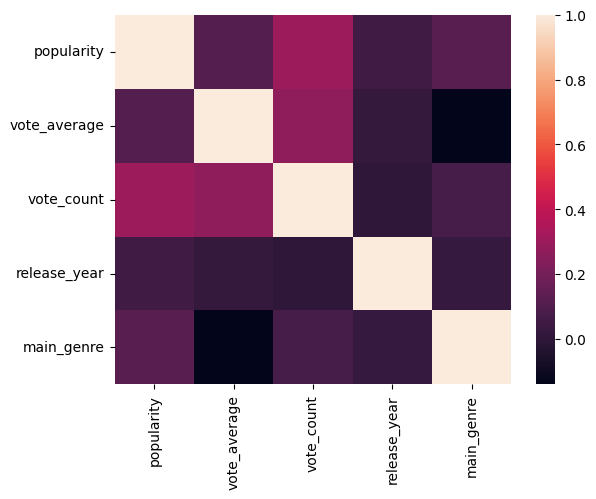

In [205]:
corr_matrix = x_train_scaled.corr()
sns.heatmap(corr_matrix)

Для фильтрации воспользуемся `feature importance`

In [206]:
# зануляем главную диагональ в матрице корреляции
np.fill_diagonal(corr_matrix.values, 0)
corr_matrix

,popularity,vote_average,vote_count,release_year,main_genre
popularity,0.000000,0.112485,0.301980,0.052525,0.121269
vote_average,0.112485,0.000000,0.271564,0.018947,-0.139922
vote_count,0.301980,0.271564,0.000000,0.001525,0.070549
release_year,0.052525,0.018947,0.001525,0.000000,0.022245
main_genre,0.121269,-0.139922,0.070549,0.022245,0.000000


In [207]:
# отфильтровываем по порогу и группируем отфильтрованные значения по каждому признаку, вычисляя сумму
feature_list = (corr_matrix.abs() > 0.07).sum(axis=1)
# сортируем по убыванию
feature_sort_list = feature_list.sort_values(ascending=False)
# фильтруем
new_features = feature_sort_list[feature_sort_list > 0].index
new_features

Index(['popularity', 'vote_average', 'vote_count', 'main_genre'], dtype='object')

**Осуществить бинарную классификацию с отфильтрованными признаками**

In [208]:
filtered_model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
# обучение
filtered_model.fit(x_train_scaled[new_features], y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

**Посчитать метрики:** *accuracy, precision, recall, f-measure*, а также составить` classification_report`

In [209]:
filtered_preds = filtered_model.predict(x_test_scaled[new_features])

In [115]:
print(f'Accuracy: {accuracy_score(y_test, filtered_preds)}')
print(f'Precision: {precision_score(y_test, filtered_preds)}')
print(f'Recall: {recall_score(y_test, filtered_preds)}')
print(f'F1-measure: {f1_score(y_test, filtered_preds)}')
print(classification_report(y_test, filtered_preds))

Accuracy: 0.9859514687100894
Precision: 0.9850746268656716
Recall: 0.9705882352941176
F1-measure: 0.9777777777777777
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1601
        True       0.99      0.97      0.98       748

    accuracy                           0.99      2349
   macro avg       0.99      0.98      0.98      2349
weighted avg       0.99      0.99      0.99      2349



**Сравнить результаты "до" и "после" фильтрации, сделать выводы**

После фильтрации признаков местрики стали еще лучше!

**Перебрать значения гиперпараметра в каком-нибудь диапазоне с использованием кросс-валидации. Построить график train/test accuracy в зависимости от значения k**

In [133]:
scaler_filter = StandardScaler()
scaler_filter.fit(x[new_features])

StandardScaler()

In [134]:
x_scaled_filtered = pd.DataFrame(scaler_filter.transform(x[new_features]), columns=new_features)
x_train_scaled_filtered = pd.DataFrame(scaler_filter.transform(x_train[new_features]), columns=new_features)
x_test_scaled_filtered = pd.DataFrame(scaler_filter.transform(x_test[new_features]), columns=new_features)

In [137]:
train_score = []
test_score = []
scaler = StandardScaler()
scaler.fit(x[cols])
for k in range(2, 30):
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, x_scaled_filtered, y, cv = 10)
    print(f"Neighbors: {k}, folds count: 10 avg score: {scores.mean()}")
    model.fit(x_train_scaled_filtered, y_train)
    pred_train = model.predict(x_train_scaled_filtered)
    pred_test = model.predict(x_test_scaled_filtered)
    train_score.append(accuracy_score(y_train, pred_train))
    test_score.append(accuracy_score(y_test, pred_test))

Neighbors: 2, folds count: 10 avg score: 0.9455022318899688
Neighbors: 3, folds count: 10 avg score: 0.9449797203906375
Neighbors: 4, folds count: 10 avg score: 0.9439095461446083
Neighbors: 5, folds count: 10 avg score: 0.9438084879795164
Neighbors: 6, folds count: 10 avg score: 0.9435914168536017
Neighbors: 7, folds count: 10 avg score: 0.9447668411392834
Neighbors: 8, folds count: 10 avg score: 0.9444438402102733
Neighbors: 9, folds count: 10 avg score: 0.9444473523213922
Neighbors: 10, folds count: 10 avg score: 0.9449762082795188
Neighbors: 11, folds count: 10 avg score: 0.9447663879636554
Neighbors: 12, folds count: 10 avg score: 0.9452962635669454
Neighbors: 13, folds count: 10 avg score: 0.945937053905241
Neighbors: 14, folds count: 10 avg score: 0.9456155257970226
Neighbors: 15, folds count: 10 avg score: 0.944660004984932
Neighbors: 16, folds count: 10 avg score: 0.9452963768608523
Neighbors: 17, folds count: 10 avg score: 0.9458307842204245
Neighbors: 18, folds count: 10 avg

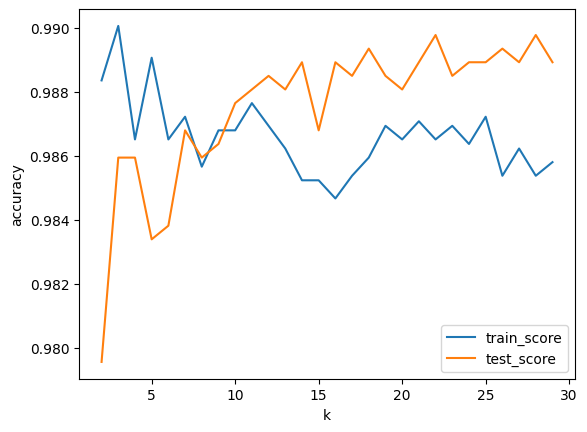

In [142]:
plt.plot(range(2, 30), train_score, label="train_score")
plt.plot(range(2, 30), test_score, label="test_score")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.legend()

# Многоклассовая классификация

**Привести описание датасета. Осуществить предобработку данных - "подчистить данные"**

Аналогично бинарной классификации

In [345]:
data = pd.read_csv('movies2.csv')

In [346]:
# загрубим значение даты выхода для группировке по годам
data['release_year'] = data["release_date"].apply(lambda e:  str(round(int(e[0:4]), -1)) + '-e')

In [347]:
#загрубим значения датасета. Выделим среди жанров фильма "главный"
data = data[data['genre_names'] != '[]']
data['main_genre'] = data["genre_names"].apply(lambda e: e.split('\'')[1])

<ipython-input-347-76eda0bdf38b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['main_genre'] = data["genre_names"].apply(lambda e: e.split('\'')[1])


In [348]:
# округление 'popularity' до десятков
data['popularity'] = data["popularity"].apply(lambda e:  round(int(e), -1))

In [369]:
bins = [0, 6.3, 7.2, 10]
labels = ['low', 'medium', 'high']
data['rating'] = pd.cut(data['vote_average'], bins=bins, labels=labels)

In [370]:
data['rating'].value_counts()

rating
medium    3920
low       3139
high      2338
Name: count, dtype: int64

In [371]:
data.drop('overview', axis=1, inplace=True)
data.drop('original_title', axis=1, inplace=True)
data.drop('release_date', axis=1, inplace=True)
data.drop('genre_names', axis=1, inplace=True)
data.drop('vote_average', axis=1, inplace=True)
data.drop('id', axis=1, inplace=True)

**Закодировать категориальные признаки при необходимости**

Предсказывать будем rating

In [372]:
category_cols = ['release_year', 'main_genre', 'rating']
dicts = []
for col in category_cols:
  print (col)
  print(len(data[col].unique()))
  keys, values = pd.factorize(data[col].unique())
  d = dict(zip(values, keys))
  data[col] = data[col].replace(d)
  dicts.append(d)

release_year
12
main_genre
18
rating
3


In [373]:
data

,popularity,vote_count,release_year,main_genre,rating
0,120,26221,0,0,0
1,170,19877,1,0,0
2,160,12001,1,0,0
3,80,15409,0,0,0
4,80,8276,2,0,0
...,...,...,...,...,...
9395,10,346,3,10,2
9396,10,1317,5,10,2
9397,20,329,3,1,2
9398,10,441,7,3,2


**Выбрать какое-нибудь значение гиперпараметра `k`**


In [374]:
k = 3

**Нормализовать данные**

In [375]:
x = data.drop('rating', axis=1)
y = data['rating']
cols = list(x.columns)

In [376]:
scaler = StandardScaler()
scaler.fit(x[cols])
scaled = scaler.transform(x[cols])
x_scaled = pd.DataFrame(scaled, columns=cols)

**Разбить выборку на обучающую и тестовую**

In [384]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.85)

**Осуществить многоклассовую классификацию**

In [385]:
model = KNeighborsClassifier(n_neighbors=k)
model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

**Посчитать метрики:** *accuracy, precision, recall, f-measure*, а также составить` classification_report`

In [386]:
preds = model.predict(x_test)

In [387]:
print(f'Accuracy: {accuracy_score(y_test, preds)}')
print(f'Precision (micro): {precision_score(y_test, preds, average="micro")}')
print(f'Recall (micro): {recall_score(y_test, preds, average="micro")}')
print(f'F1-measure (micro): {f1_score(y_test, preds, average="micro")}')
print(classification_report(y_test, preds))

Accuracy: 0.3730496453900709
Precision (micro): 0.3730496453900709
Recall (micro): 0.3730496453900709
F1-measure (micro): 0.3730496453900709
              precision    recall  f1-score   support

           0       0.31      0.39      0.35       371
           1       0.42      0.36      0.39       593
           2       0.38      0.37      0.38       446

    accuracy                           0.37      1410
   macro avg       0.37      0.37      0.37      1410
weighted avg       0.38      0.37      0.37      1410



**Построить** `сorrelation heatmap` и/или воспользоваться методом `corr()`. **Выбрать наиболее важные признаки** эвристически или на основании каких-нибудь вычислений

<Axes: >

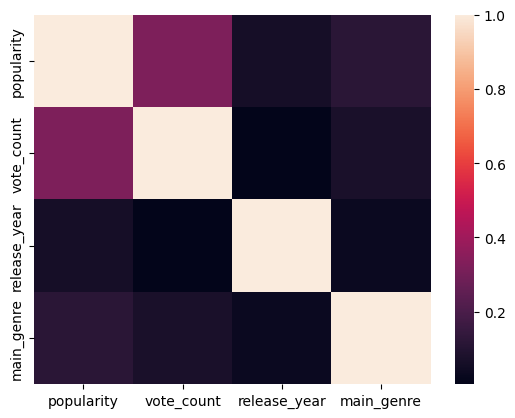

In [388]:
corr_matrix = x_train.corr()
sns.heatmap(corr_matrix)

In [389]:
# зануляем главную диагональ в матрице корреляции
np.fill_diagonal(corr_matrix.values, 0)
# отфильтровываем по порогу и группируем отфильтрованные значения по каждому признаку, вычисляя сумму
feature_list = (corr_matrix.abs() > 0.07).sum(axis=1)
# сортируем по убыванию
feature_sort_list = feature_list.sort_values(ascending=False)
# фильтруем
new_features = feature_sort_list[feature_sort_list > 0].index
new_features

Index(['popularity', 'vote_count', 'main_genre'], dtype='object')

**Осуществить многоклассовую классификацию с отфильтрованными признаками**

In [390]:
filtered_model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
# обучение
filtered_model.fit(x_train[new_features], y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

**Посчитать метрики:** *accuracy, precision, recall, f-measure*, а также составить` classification_report`

In [391]:
preds_filtered = filtered_model.predict(x_test[new_features])

In [392]:
print(f'Accuracy: {accuracy_score(y_test, preds_filtered)}')
print(f'Precision (micro): {precision_score(y_test, preds_filtered, average="micro")}')
print(f'Recall (micro): {recall_score(y_test, preds_filtered, average="micro")}')
print(f'F1-measure (micro): {f1_score(y_test, preds_filtered, average="micro")}')
print(classification_report(y_test, preds_filtered))

Accuracy: 0.3773049645390071
Precision (micro): 0.3773049645390071
Recall (micro): 0.3773049645390071
F1-measure (micro): 0.3773049645390071
              precision    recall  f1-score   support

           0       0.31      0.40      0.35       371
           1       0.43      0.37      0.40       593
           2       0.39      0.37      0.38       446

    accuracy                           0.38      1410
   macro avg       0.38      0.38      0.38      1410
weighted avg       0.38      0.38      0.38      1410



**Сравнить результаты "до" и "после" фильтрации, сделать выводы**

Точность  модели практически не изменилась, однако теперь она обеспечивается меньшим количеством признаков

**Перебрать значения гиперпараметра в каком-нибудь диапазоне с использованием кросс-валидации. Построить график train/test accuracy в зависимости от значения k**

In [393]:
scaler_filter = StandardScaler()
scaler_filter.fit(x[new_features])
x_scaled_filtered = pd.DataFrame(scaler_filter.transform(x[new_features]), columns=new_features)
x_train_scaled_filtered = pd.DataFrame(scaler_filter.transform(x_train[new_features]), columns=new_features)
x_test_scaled_filtered = pd.DataFrame(scaler_filter.transform(x_test[new_features]), columns=new_features)

In [396]:
train_score = []
test_score = []

for k in range(2, 100):
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, x_scaled_filtered, y, cv = 10)
    print(f"Neighbors: {k}, folds count: 10 avg score: {scores.mean()}")
    model.fit(x_train_scaled_filtered, y_train)
    pred_train = model.predict(x_train_scaled_filtered)
    pred_test = model.predict(x_test_scaled_filtered)
    train_score.append(accuracy_score(y_train, pred_train))
    test_score.append(accuracy_score(y_test, pred_test))

Neighbors: 2, folds count: 10 avg score: 0.39566276935626404
Neighbors: 3, folds count: 10 avg score: 0.41917567353227747
Neighbors: 4, folds count: 10 avg score: 0.4397122334760836
Neighbors: 5, folds count: 10 avg score: 0.4356720594566424
Neighbors: 6, folds count: 10 avg score: 0.4468423855165069
Neighbors: 7, folds count: 10 avg score: 0.459721410282555
Neighbors: 8, folds count: 10 avg score: 0.45408152629551585
Neighbors: 9, folds count: 10 avg score: 0.45801848956563107
Neighbors: 10, folds count: 10 avg score: 0.4599328167131172
Neighbors: 11, folds count: 10 avg score: 0.467701606507602
Neighbors: 12, folds count: 10 avg score: 0.4662119049237532
Neighbors: 13, folds count: 10 avg score: 0.4716407223619513
Neighbors: 14, folds count: 10 avg score: 0.48089513515963106
Neighbors: 15, folds count: 10 avg score: 0.4797267350961866
Neighbors: 16, folds count: 10 avg score: 0.4784467405342941
Neighbors: 17, folds count: 10 avg score: 0.4805770058686244
Neighbors: 18, folds count: 1

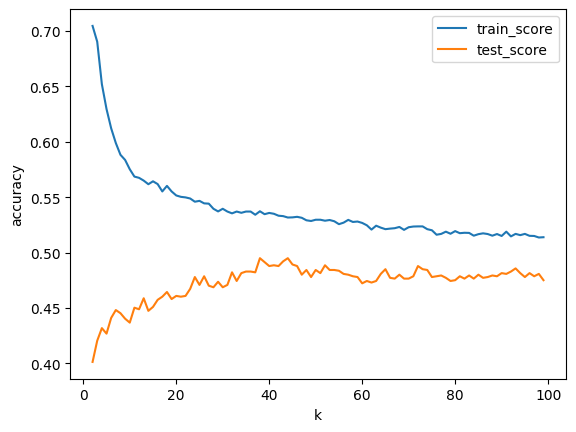

In [397]:
plt.plot(range(2, 100), train_score, label="train_score")
plt.plot(range(2, 100), test_score, label="test_score")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.legend()

**Для лучшего классификатора привести метрики, classification_report, построить confusion matrix**

Наилучший результат на тестовой выборке при k=6

In [398]:
test_score.index(max(test_score[1:]))

36

In [399]:
filtered_model = KNeighborsClassifier(n_neighbors=36)
# обучение
filtered_model.fit(x_train_scaled_filtered, y_train)

KNeighborsClassifier(n_neighbors=36)

In [400]:
preds = model.predict(x_test_scaled_filtered)

In [401]:
print(f'Accuracy: {accuracy_score(y_test, preds)}')
print(f'Precision (micro): {precision_score(y_test, preds, average="micro")}')
print(f'Recall (micro): {recall_score(y_test, preds, average="micro")}')
print(f'F1-measure (micro): {f1_score(y_test, preds, average="micro")}')
print(classification_report(y_test, preds))

Accuracy: 0.475177304964539
Precision (micro): 0.475177304964539
Recall (micro): 0.475177304964539
F1-measure (micro): 0.475177304964539
              precision    recall  f1-score   support

           0       0.57      0.22      0.32       371
           1       0.45      0.55      0.50       593
           2       0.48      0.58      0.52       446

    accuracy                           0.48      1410
   macro avg       0.50      0.45      0.45      1410
weighted avg       0.49      0.48      0.46      1410



<Axes: >

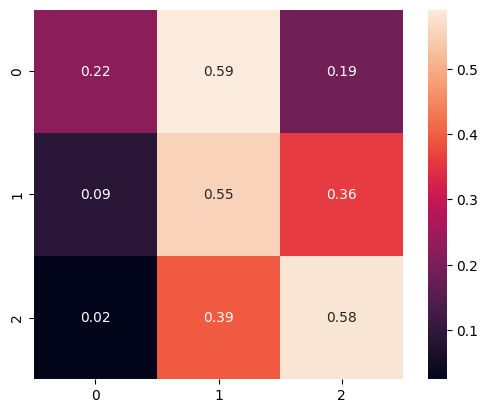

In [402]:
from sklearn.metrics import confusion_matrix
sns.heatmap(data=confusion_matrix(y_test, preds, normalize='true'), square=True, annot=True, fmt='.2f')